- model : resnet50
- trans : transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
- optim : Adam(resnet50.fc.parameters(pretrained=True), lr = 0.002)
- lr_scheduler : StepLR(optim, step_size=5, gamma=0.0002)

In [1]:
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import joblib
import time, copy

# Model
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
from torchvision.models import resnet50

# 성능 평가
from sklearn.metrics import f1_score

# 시각화
import matplotlib.pyplot as plt

In [2]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [3]:
train_set = torchvision.datasets.ImageFolder(root = './Train_faabad06fe/Train',
                                             transform = trans)
val_set = torchvision.datasets.ImageFolder(root = './Validation_9857834a3b',
                                           transform = trans)

In [4]:
print(train_set.classes)
print(val_set.classes)

['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']
['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']


In [5]:
image_set = {'train' : train_set, 'val' : val_set}
image_loaders = {x: DataLoader(image_set[x], batch_size=32, shuffle=True, num_workers=4)
                 for x in ['train', 'val']}
dataset_sizes = {x: len(image_set[x]) for x in ['train', 'val']}
class_names = image_set['train'].classes

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [7]:
# 성능 시각화를 위한 losses, flscores 변수 선언.
losses = {'train':[], 'val':[]}
flscores = {'train':[], 'val':[]}

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1score = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)마다 train과 val 단계 진행.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정.
            else:
                model.eval()   # 모델을 평가 모드로 설정.

            running_loss = 0.0
            running_f1score = []

            # 데이터를 반복.
            for inputs, labels in image_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정.
                optimizer.zero_grad()
                
                # 학습.
                if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')

                        # 역전파 + 최적화 진행.
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()
                
                # 평가.
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')
                        
                # 통계.
                running_loss += loss.item() * inputs.size(0)
                running_f1score.append(f1score)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1score = sum(running_f1score) / len(running_f1score)
            
            losses[phase].append(epoch_loss)
            flscores[phase].append(epoch_f1score)
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1-Score: {epoch_f1score:.4f}')

            # 모델 deep copy.
            if phase == 'val' and epoch_f1score > best_f1score:
                best_f1score = epoch_f1score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1score:4f}')

    # 가장 나은 모델 가중치를 불러옴.
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_resnet50 = torchvision.models.resnet50(pretrained=True)

for param in model_resnet50.parameters():
    param.requires_grad = False

In [10]:
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 5)
model_resnet50 = model_resnet50.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_resnet50.fc.parameters(), lr = 0.002)

# 5 에폭마다 0.005씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.0002)

In [12]:
best_resnet50 = train_model(model_resnet50, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5840 F1-Score: 0.6532
val Loss: 0.3183 F1-Score: 0.8326

Epoch 1/24
----------
train Loss: 0.3279 F1-Score: 0.7843
val Loss: 0.4472 F1-Score: 0.6773

Epoch 2/24
----------
train Loss: 0.3087 F1-Score: 0.8020
val Loss: 0.2010 F1-Score: 0.8559

Epoch 3/24
----------
train Loss: 0.2339 F1-Score: 0.8454
val Loss: 0.2508 F1-Score: 0.8285

Epoch 4/24
----------
train Loss: 0.2216 F1-Score: 0.8554
val Loss: 0.2048 F1-Score: 0.8553

Epoch 5/24
----------
train Loss: 0.2122 F1-Score: 0.8539
val Loss: 0.2294 F1-Score: 0.8083

Epoch 6/24
----------
train Loss: 0.2069 F1-Score: 0.8577
val Loss: 0.1783 F1-Score: 0.8812

Epoch 7/24
----------
train Loss: 0.2027 F1-Score: 0.8634
val Loss: 0.1992 F1-Score: 0.8552

Epoch 8/24
----------
train Loss: 0.1979 F1-Score: 0.8649
val Loss: 0.1904 F1-Score: 0.8815

Epoch 9/24
----------
train Loss: 0.1958 F1-Score: 0.8645
val Loss: 0.1980 F1-Score: 0.8623

Epoch 10/24
----------
train Loss: 0.1941 F1-Score: 0.8678
val Loss: 0.1866 F1-Score: 0.8899

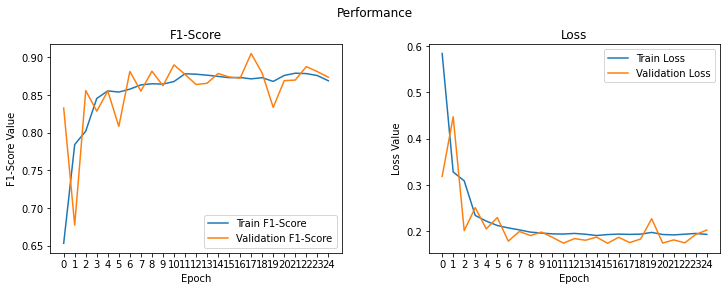

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 25 #에폭사이즈
ax1.plot(range(epochs), flscores['train'], label='Train F1-Score')
ax1.plot(range(epochs), flscores['val'], label='Validation F1-Score')
ax1.set_xticks(np.arange(0, epochs))
ax1.set_ylabel('F1-Score Value')
ax1.set_xlabel('Epoch')
ax1.set_title('F1-Score')
l1 = ax1.legend(loc="best")

ax2.plot(range(epochs), losses['train'], label='Train Loss')
ax2.plot(range(epochs), losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [14]:
filname = 'best_Resnet50_nom0485'
f.savefig(filname, dpi = 300)

In [15]:
best_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
torch.save(best_resnet50, 'ResNet50ModelSave.pt')

In [17]:
joblib.dump(best_resnet50, 'ResNet50ModelSave.pkl')

['ResNet50ModelSave.pkl']